In [1]:
# Import Modules
# Refactor so module loading is in src files
import os
import tarfile
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from pathlib import Path
import sys
import matplotlib.pyplot as plt

In [ ]:
# Load data with Pandas
#CURRENT_DIR = Path.cwd()
#path_to_root = CURRENT_DIR.joinpath('..')
#sys.path.append(path_to_root)

In [3]:
# Load Data with Pandas
#from src.data import make_dataset
from src.data.make_dataset import load_housing_data

base_dir = Path.cwd().parents[0]
data_dir = base_dir.joinpath("data").joinpath("interim")
housing = load_housing_data(data_dir)



In [4]:
# Explore housing data
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We notice that the `ocean_proximity` column is of class `object.` Let's find out what it contains.

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

For a description of numerical attributes:

In [7]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

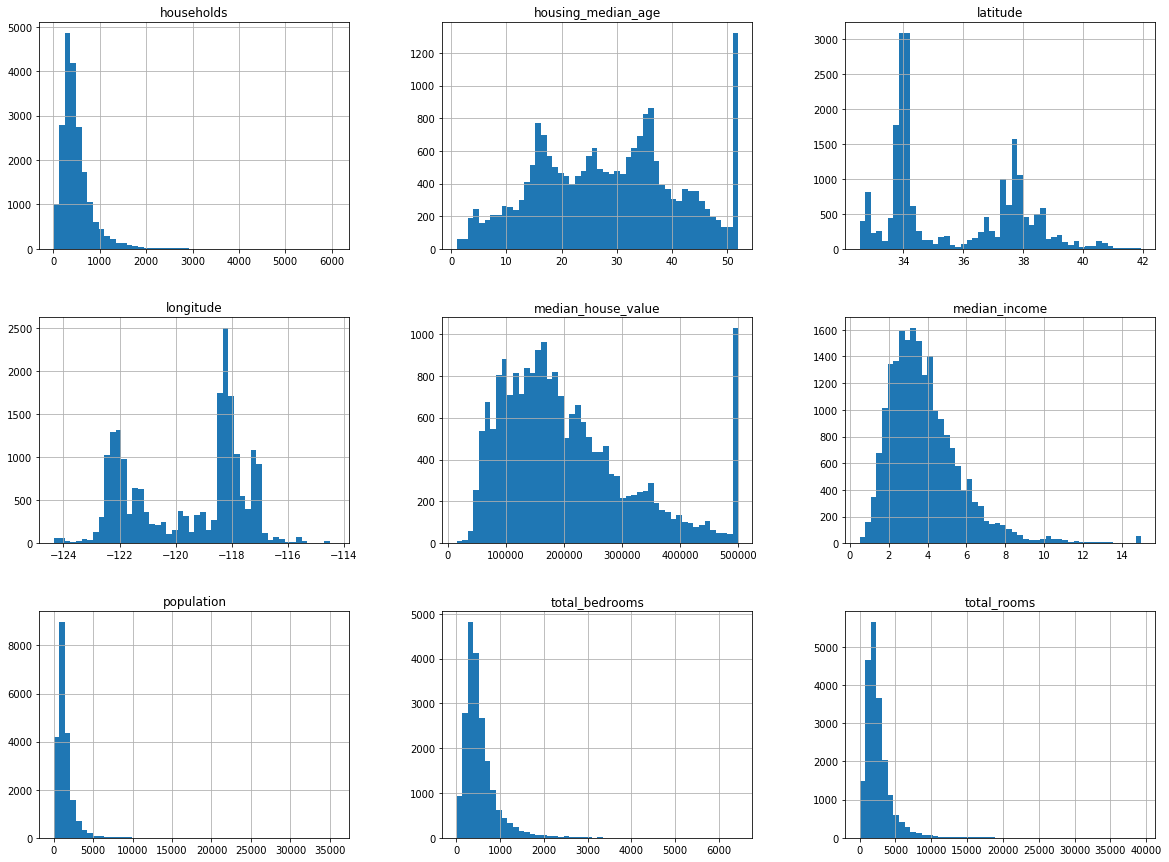

In [8]:
%matplotlib inline
housing.hist(bins=50, figsize=(20,15))
plt.show()

Some notes:
* Median Income is not in USD; scaled and capped at 15.0001 (above) and .4999 (below).
* Median housing age and value also capped -- the latter may be a problem.
* Attributes in general have very different scales
* Tail-heavy histograms

## Make a Test Set

In [ ]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

But this approach has problems and "will break the next time you fetch an updated dataset." One approach is to run it once, save to separate files, and use them forever onward. However, we could use hash function which acts as pseudo RNG, but deterministically, based on a unique identifier. If we know that, e.g., the last three digits range from 001 to 100, and are uniformly distributed in that range, we could take as our test set all with hashes ending in 001-020.

It's also possible to hash stable features (such as lat/long) to split

In [ ]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Lastly, this can also be done with `scikitlearn`

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state = 42)

We may need to do stratified sampling in some cases; e.g, where there are rare but important categories that need to be represented in both training and test sets.

In [ ]:
help(train_test_split)